In [1]:
# Bloque 1: Configuración inicial (mejorado)
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import nltk
import joblib
import tkinter as tk
from tkinter import scrolledtext, ttk, messagebox
import os
from datetime import datetime
import warnings

# Configuración de parámetros centralizados
CONFIG = {
    'DATA_FILE': 'phishing_email.csv',
    'TEXT_COLUMN': 'text_combined',
    'LABEL_COLUMN': 'label',
    'MODEL_FILE': 'phishing_email_model.pkl',
    'VECTORIZER_FILE': 'tfidf_vectorizer.pkl',
    'MAX_FEATURES': 5000,
    'TEST_SIZE': 0.2,
    'RANDOM_STATE': 42,
    'MAX_ITER': 1000
}

# Configurar matplotlib para español
plt.style.use('default')
warnings.filterwarnings('ignore')

# Descargar recursos de NLTK
try:
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    print("✅ NLTK configurado correctamente")
except Exception as e:
    print(f"⚠️ Error configurando NLTK: {e}")
    stop_words = set()

print("🚀 Configuración inicial completada")

✅ NLTK configurado correctamente
🚀 Configuración inicial completada


📂 Cargando el conjunto de datos...
✅ Dataset cargado exitosamente: (82486, 2)

📊 Información del dataset:
   - Filas: 82,486
   - Columnas: 2
   - Columnas disponibles: ['text_combined', 'label']
✅ Columnas requeridas encontradas: ['text_combined', 'label']

📋 Primeras 5 filas del dataset:
                                       text_combined  label
0  hpl nom may 25 2001 see attached file hplno 52...      0
1  nom actual vols 24 th forwarded sabrae zajac h...      0
2  enron actuals march 30 april 1 201 estimated a...      0
3  hpl nom may 30 2001 see attached file hplno 53...      0
4  hpl nom june 1 2001 see attached file hplno 60...      0

🔍 Información detallada:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1

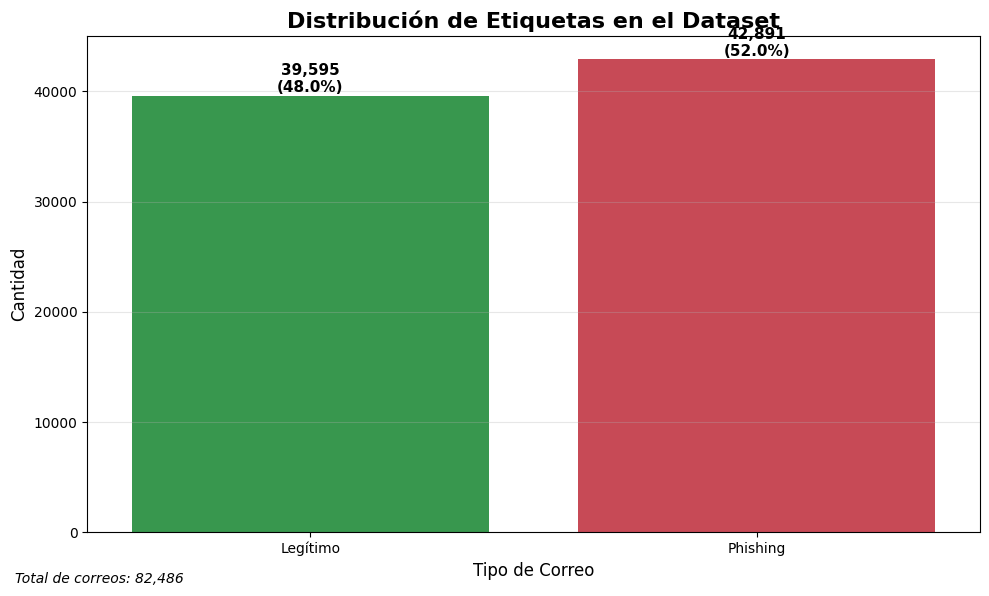


📊 Estadísticas detalladas:
   - Legítimo: 39,595 correos (48.00%)
   - Phishing: 42,891 correos (52.00%)

⚖️ Balance del dataset: 0.923
   ✅ Dataset bien balanceado
✅ Exploración de datos completada


In [2]:
# Bloque 2: Carga y exploración del dataset (CORREGIDO)
print("📂 Cargando el conjunto de datos...")

# Verificar que el archivo existe
if not os.path.exists(CONFIG['DATA_FILE']):
    print(f"❌ Error: El archivo {CONFIG['DATA_FILE']} no se encuentra")
    print("📁 Archivos disponibles en el directorio:")
    for file in os.listdir('.'):
        if file.endswith('.csv'):
            print(f"   - {file}")
    raise FileNotFoundError(f"El archivo {CONFIG['DATA_FILE']} no se encuentra")

try:
    data = pd.read_csv(CONFIG['DATA_FILE'])
    print(f"✅ Dataset cargado exitosamente: {data.shape}")
except Exception as e:
    print(f"❌ Error al cargar el dataset: {e}")
    raise

# Mostrar información del dataset
print("\n📊 Información del dataset:")
print(f"   - Filas: {data.shape[0]:,}")
print(f"   - Columnas: {data.shape[1]}")
print(f"   - Columnas disponibles: {list(data.columns)}")

# Verificar columnas requeridas
required_columns = [CONFIG['TEXT_COLUMN'], CONFIG['LABEL_COLUMN']]
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    print(f"❌ Faltan las columnas: {missing_columns}")
    print(f"💡 Sugerencia: Ajusta CONFIG['TEXT_COLUMN'] y CONFIG['LABEL_COLUMN']")
    raise ValueError(f"Faltan las columnas: {missing_columns}")

print(f"✅ Columnas requeridas encontradas: {required_columns}")

# Mostrar primeras filas
print("\n📋 Primeras 5 filas del dataset:")
print(data.head())

# Información de tipos de datos
print("\n🔍 Información detallada:")
print(data.info())

# Distribución de etiquetas
print(f"\n📈 Distribución de etiquetas en '{CONFIG['LABEL_COLUMN']}':")
label_counts = data[CONFIG['LABEL_COLUMN']].value_counts().sort_index()
print(label_counts)

# Crear mapeo de etiquetas para visualización
label_mapping = {0: 'Legítimo', 1: 'Phishing'}
data_viz = data.copy()
data_viz['label_text'] = data_viz[CONFIG['LABEL_COLUMN']].map(label_mapping)

# Visualización CORREGIDA de la distribución
plt.figure(figsize=(10, 6))

# Crear el gráfico con las etiquetas correctas
sns.countplot(data=data_viz, x='label_text', palette=['#28a745', '#dc3545'])
plt.title('Distribución de Etiquetas en el Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Tipo de Correo', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)

# Añadir valores en las barras
for i, (label, count) in enumerate(label_counts.items()):
    label_name = label_mapping[label]
    plt.text(i, count + 50, f'{count:,}\n({count/len(data)*100:.1f}%)', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Mejorar el diseño
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Añadir información adicional
plt.figtext(0.02, 0.02, f'Total de correos: {len(data):,}', fontsize=10, style='italic')

plt.show()

# Mostrar estadísticas detalladas
print("\n📊 Estadísticas detalladas:")
for label, count in label_counts.items():
    label_name = label_mapping[label]
    percentage = (count / len(data)) * 100
    print(f"   - {label_name}: {count:,} correos ({percentage:.2f}%)")

# Verificar balance del dataset
ratio = min(label_counts) / max(label_counts)
print(f"\n⚖️ Balance del dataset: {ratio:.3f}")
if ratio > 0.8:
    print("   ✅ Dataset bien balanceado")
elif ratio > 0.6:
    print("   🟡 Dataset moderadamente balanceado")
else:
    print("   🔴 Dataset desbalanceado")

print("✅ Exploración de datos completada")

In [3]:
# Bloque 3: Limpieza de datos (mejorado)
print("🧹 Iniciando limpieza de datos...")

# Verificar valores nulos
print("🔍 Verificando valores nulos:")
null_info = data.isnull().sum()
print(null_info[null_info > 0] if null_info.sum() > 0 else "✅ No hay valores nulos")

# Limpiar datos
initial_shape = data.shape[0]
data = data.dropna(subset=[CONFIG['TEXT_COLUMN'], CONFIG['LABEL_COLUMN']])
final_shape = data.shape[0]

print(f"📊 Estadísticas de limpieza:")
print(f"   - Filas iniciales: {initial_shape:,}")
print(f"   - Filas después de limpiar: {final_shape:,}")
print(f"   - Filas eliminadas: {initial_shape - final_shape:,}")

# Verificar tipos de datos en las etiquetas
print(f"\n🏷️ Tipos únicos en '{CONFIG['LABEL_COLUMN']}':")
unique_labels = data[CONFIG['LABEL_COLUMN']].unique()
print(f"   - Valores únicos: {unique_labels}")
print(f"   - Tipos de datos: {data[CONFIG['LABEL_COLUMN']].dtype}")

# Verificar que las etiquetas sean 0 y 1
if not set(unique_labels).issubset({0, 1}):
    print("⚠️ Advertencia: Las etiquetas no son 0 y 1. Convirtiendo...")
    # Mapear etiquetas si es necesario
    label_mapping = {unique_labels[0]: 0, unique_labels[1]: 1}
    data[CONFIG['LABEL_COLUMN']] = data[CONFIG['LABEL_COLUMN']].map(label_mapping)
    print(f"✅ Etiquetas mapeadas: {label_mapping}")

print("✅ Limpieza de datos completada")

🧹 Iniciando limpieza de datos...
🔍 Verificando valores nulos:
✅ No hay valores nulos
📊 Estadísticas de limpieza:
   - Filas iniciales: 82,486
   - Filas después de limpiar: 82,486
   - Filas eliminadas: 0

🏷️ Tipos únicos en 'label':
   - Valores únicos: [0 1]
   - Tipos de datos: int64
✅ Limpieza de datos completada


In [4]:
# Bloque 4: Preprocesamiento de texto (mejorado)
def preprocess_text(text):
    """
    Preprocesa el texto eliminando caracteres especiales y stopwords
    """
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    
    # Eliminar stopwords
    words = [word for word in text.split() if word not in stop_words and len(word) > 2]
    
    return ' '.join(words)

print("🔤 Iniciando preprocesamiento de texto...")

# Aplicar preprocesamiento
data['cleaned_text'] = data[CONFIG['TEXT_COLUMN']].apply(preprocess_text)

# Verificar resultados del preprocesamiento
print("📝 Ejemplo de preprocesamiento:")
sample_idx = 0
print(f"\n🔸 Original:")
print(f"   {data[CONFIG['TEXT_COLUMN']].iloc[sample_idx][:200]}...")
print(f"\n🔸 Procesado:")
print(f"   {data['cleaned_text'].iloc[sample_idx][:200]}...")

# Verificar textos vacíos después del preprocesamiento
empty_texts = data['cleaned_text'].str.len() == 0
if empty_texts.sum() > 0:
    print(f"\n⚠️ Encontrados {empty_texts.sum()} textos vacíos después del preprocesamiento")
    data = data[~empty_texts]
    print(f"✅ Textos vacíos eliminados. Filas restantes: {data.shape[0]:,}")

print("✅ Preprocesamiento de texto completado")

🔤 Iniciando preprocesamiento de texto...
📝 Ejemplo de preprocesamiento:

🔸 Original:
   hpl nom may 25 2001 see attached file hplno 525 xls hplno 525 xls...

🔸 Procesado:
   hpl nom may see attached file hplno xls hplno xls...

⚠️ Encontrados 3 textos vacíos después del preprocesamiento
✅ Textos vacíos eliminados. Filas restantes: 82,483
✅ Preprocesamiento de texto completado


In [5]:
# Bloque 5: Extracción de características con TF-IDF (mejorado)
print("🔢 Iniciando extracción de características con TF-IDF...")

# Configurar TF-IDF
tfidf = TfidfVectorizer(
    max_features=CONFIG['MAX_FEATURES'],
    min_df=2,  # Ignorar términos que aparecen en menos de 2 documentos
    max_df=0.95,  # Ignorar términos que aparecen en más del 95% de documentos
    ngram_range=(1, 2),  # Usar unigramas y bigramas
    lowercase=True,
    stop_words='english'
)

# Ajustar y transformar el texto
X = tfidf.fit_transform(data['cleaned_text'])
y = data[CONFIG['LABEL_COLUMN']].values

print(f"📊 Información de la matriz TF-IDF:")
print(f"   - Forma de la matriz: {X.shape}")
print(f"   - Características extraídas: {X.shape[1]:,}")
print(f"   - Densidad de la matriz: {(X.nnz / (X.shape[0] * X.shape[1])) * 100:.2f}%")

# Mostrar las características más importantes
feature_names = tfidf.get_feature_names_out()
print(f"\n🔤 Primeras 10 características:")
print(f"   {list(feature_names[:10])}")

print("✅ Extracción de características completada")

🔢 Iniciando extracción de características con TF-IDF...
📊 Información de la matriz TF-IDF:
   - Forma de la matriz: (82483, 5000)
   - Características extraídas: 5,000
   - Densidad de la matriz: 1.36%

🔤 Primeras 10 características:
   ['aaron', 'abacha', 'abidjan', 'ability', 'able', 'abroad', 'absolute', 'absolutely', 'abstract', 'abstracts']
✅ Extracción de características completada


Realizando validación cruzada...
Media de Accuracy: 95.51% ± (4.09)%


<Figure size 800x500 with 0 Axes>

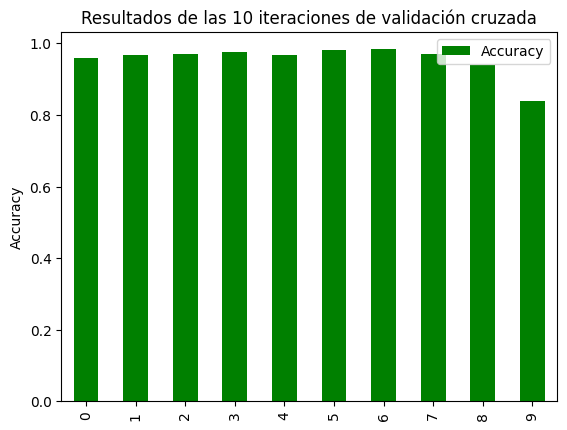

In [6]:
# Bloque 6: Validación cruzada
print("Realizando validación cruzada...")
model = LogisticRegression(max_iter=1000)
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print(f"Media de Accuracy: {scores.mean()*100:.2f}% ± ({scores.std()*100:.2f})%")

plt.figure(figsize=(8, 5))
pd.DataFrame(scores, columns=['Accuracy']).plot.bar(color='green')
plt.title("Resultados de las 10 iteraciones de validación cruzada")
plt.ylabel("Accuracy")
plt.show()

🔄 Implementando early stopping equivalente...
✅ Mejor valor de C encontrado: 0.7743
📊 Accuracy de validación: 0.9516 ± 0.0242


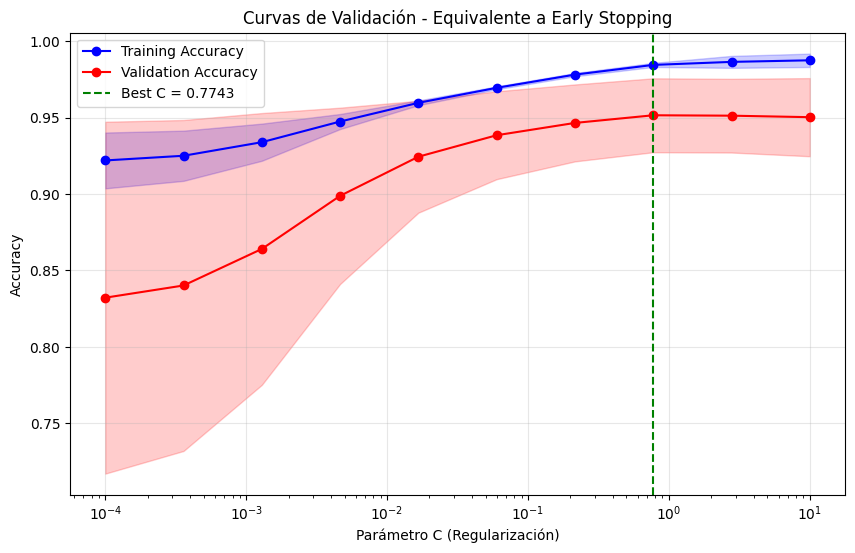

In [7]:
# Bloque 6A: Validación cruzada con early stopping simulado
from sklearn.model_selection import validation_curve
import numpy as np

print("🔄 Implementando early stopping equivalente...")

# Simular early stopping probando diferentes valores de C
param_range = np.logspace(-4, 1, 10)  # C values from 0.0001 to 10
train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    X, y, 
    param_name='C', 
    param_range=param_range,
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

# Calcular medias y desviaciones
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Encontrar el mejor C (equivalente a early stopping)
best_idx = np.argmax(val_mean)
best_C = param_range[best_idx]

print(f"✅ Mejor valor de C encontrado: {best_C:.4f}")
print(f"📊 Accuracy de validación: {val_mean[best_idx]:.4f} ± {val_std[best_idx]:.4f}")

# Visualizar curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.semilogx(param_range, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.semilogx(param_range, val_mean, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
plt.axvline(x=best_C, color='green', linestyle='--', label=f'Best C = {best_C:.4f}')
plt.xlabel('Parámetro C (Regularización)')
plt.ylabel('Accuracy')
plt.title('Curvas de Validación - Equivalente a Early Stopping')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

📈 Generando curvas de aprendizaje...


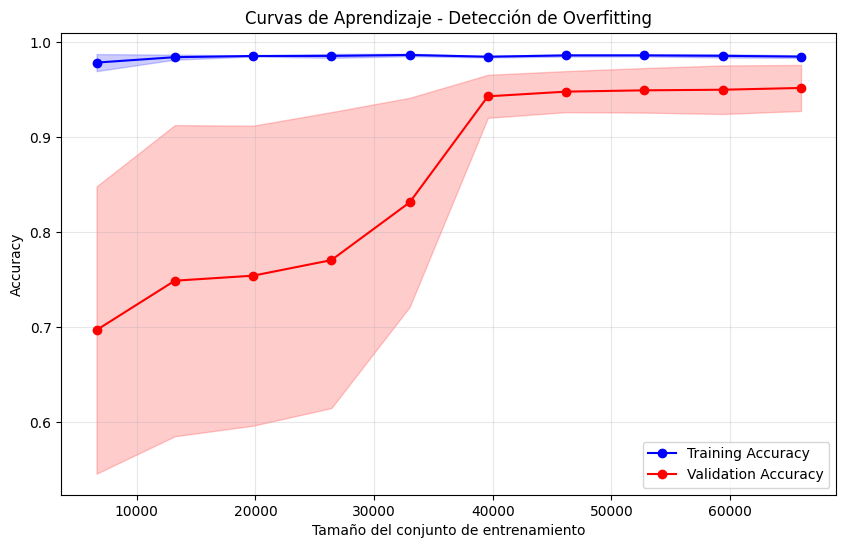

✅ Modelo converge bien - No hay overfitting significativo


In [8]:
# Bloque 6B: Curvas de aprendizaje
from sklearn.model_selection import learning_curve

print("📈 Generando curvas de aprendizaje...")

# Tamaños de muestra para evaluar
train_sizes = np.linspace(0.1, 1.0, 10)

# Generar curvas de aprendizaje
train_sizes_abs, train_scores_lc, val_scores_lc = learning_curve(
    LogisticRegression(max_iter=1000, class_weight='balanced', C=best_C),
    X, y,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Calcular estadísticas
train_mean_lc = np.mean(train_scores_lc, axis=1)
train_std_lc = np.std(train_scores_lc, axis=1)
val_mean_lc = np.mean(val_scores_lc, axis=1)
val_std_lc = np.std(val_scores_lc, axis=1)

# Visualizar curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean_lc, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes_abs, train_mean_lc - train_std_lc, 
                 train_mean_lc + train_std_lc, alpha=0.2, color='blue')
plt.plot(train_sizes_abs, val_mean_lc, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes_abs, val_mean_lc - val_std_lc, 
                 val_mean_lc + val_std_lc, alpha=0.2, color='red')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Accuracy')
plt.title('Curvas de Aprendizaje - Detección de Overfitting')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Verificar convergencia (equivalente a early stopping)
gap = train_mean_lc - val_mean_lc
if gap[-1] < 0.05:  # Gap menor al 5%
    print("✅ Modelo converge bien - No hay overfitting significativo")
else:
    print(f"⚠️ Posible overfitting detectado - Gap: {gap[-1]:.3f}")

In [9]:
# Bloque 7: Entrenamiento del modelo
print("Dividiendo datos en entrenamiento y prueba...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Entrenando el modelo...")
model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1)
model.fit(X_train, y_train)
joblib.dump(model, 'phishing_email_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

Dividiendo datos en entrenamiento y prueba...
Entrenando el modelo...


['tfidf_vectorizer.pkl']

Precisión del modelo en conjunto de prueba: 97.03%


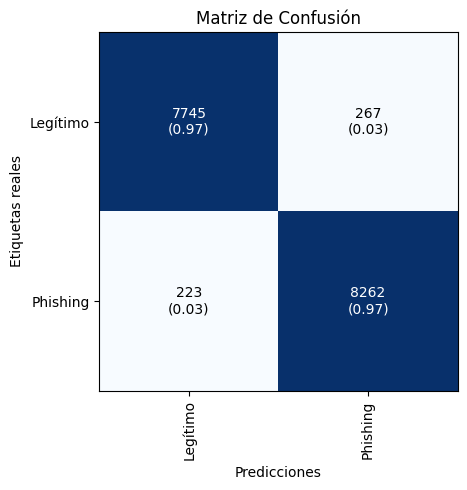

Reporte de Clasificación:
              precision    recall  f1-score   support

    Legítimo       0.97      0.97      0.97      8012
    Phishing       0.97      0.97      0.97      8485

    accuracy                           0.97     16497
   macro avg       0.97      0.97      0.97     16497
weighted avg       0.97      0.97      0.97     16497



In [10]:
# Bloque 8: Evaluación del rendimiento
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"Precisión del modelo en conjunto de prueba: {accuracy * 100:.2f}%")

labels = ['Legítimo', 'Phishing']
mc = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=mc, figsize=(5, 5), show_normed=True)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel('Predicciones')
ax.set_ylabel('Etiquetas reales')
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

reporte = classification_report(y_test, y_pred, target_names=labels)
print("Reporte de Clasificación:")
print(reporte)

In [11]:
# Bloque 9: Interfaz gráfica mejorada con correos de prueba (CORREGIDO)
print("🔍 Verificando archivos del modelo...")

# Verificar que los archivos del modelo existen
model_files = [CONFIG['MODEL_FILE'], CONFIG['VECTORIZER_FILE']]
missing_files = [f for f in model_files if not os.path.exists(f)]

if missing_files:
    print(f"❌ Error: Los siguientes archivos no se encuentran: {missing_files}")
    print("💡 Por favor, ejecuta primero los bloques de entrenamiento del modelo.")
    raise FileNotFoundError("Archivos del modelo no encontrados")

try:
    model_loaded = joblib.load(CONFIG['MODEL_FILE'])
    tfidf_loaded = joblib.load(CONFIG['VECTORIZER_FILE'])
    print("✅ Modelo y vectorizador cargados exitosamente")
except Exception as e:
    print(f"❌ Error al cargar el modelo: {e}")
    raise

class PhishingDetectorGUI:
    def __init__(self):
        self.model = model_loaded
        self.tfidf = tfidf_loaded
        self.stop_words = stop_words
        self.current_sample_emails = []
        self.setup_gui()
        
    def setup_gui(self):
        """Configurar interfaz gráfica mejorada"""
        self.app = tk.Tk()
        self.app.title("🛡️ Detector de Phishing Avanzado")
        self.app.geometry("900x700")
        self.app.configure(bg="#f8f9fa")
        
        # Configurar estilos
        self.setup_styles()
        
        # Crear notebook para pestañas
        self.notebook = ttk.Notebook(self.app)
        self.notebook.pack(fill="both", expand=True, padx=10, pady=10)
        
        # Crear pestañas
        self.create_detector_tab()
        self.create_test_emails_tab()
        self.create_statistics_tab()
        
    def setup_styles(self):
        """Configurar estilos personalizados"""
        self.style = ttk.Style()
        self.style.theme_use('clam')
        
        # Configurar estilos de botones
        self.style.configure('Success.TButton', foreground='white', background='#28a745')
        self.style.configure('Danger.TButton', foreground='white', background='#dc3545')
        self.style.configure('Info.TButton', foreground='white', background='#17a2b8')
        
    def create_detector_tab(self):
        """Crear pestaña principal del detector"""
        detector_frame = ttk.Frame(self.notebook)
        self.notebook.add(detector_frame, text="🔍 Detector")
        
        # Frame principal con padding
        main_frame = ttk.Frame(detector_frame, padding="20")
        main_frame.pack(fill="both", expand=True)
        
        # Título
        title_label = tk.Label(
            main_frame,
            text="🛡️ Detector de Correos Phishing",
            font=("Helvetica", 18, "bold"),
            bg="#f8f9fa",
            fg="#212529"
        )
        title_label.pack(pady=(0, 20))
        
        # Instrucciones
        instructions = tk.Label(
            main_frame,
            text="Pegue aquí el contenido del correo electrónico que desea analizar:",
            font=("Helvetica", 12),
            bg="#f8f9fa",
            fg="#6c757d"
        )
        instructions.pack(anchor="w", pady=(0, 10))
        
        # Campo de texto mejorado
        text_frame = ttk.Frame(main_frame)
        text_frame.pack(fill="both", expand=True, pady=(0, 15))
        
        self.text_input = scrolledtext.ScrolledText(
            text_frame,
            height=8,
            width=100,
            font=("Consolas", 11),
            wrap="word",
            borderwidth=2,
            relief="groove"
        )
        self.text_input.pack(fill="both", expand=True)
        
        # Frame para botones
        button_frame = ttk.Frame(main_frame)
        button_frame.pack(fill="x", pady=15)
        
        # Botones con iconos
        self.analyze_button = ttk.Button(
            button_frame,
            text="🔍 Analizar Correo",
            command=self.analyze_email,
            style="Success.TButton"
        )
        self.analyze_button.pack(side="left", padx=(0, 10))
        
        self.clear_button = ttk.Button(
            button_frame,
            text="🗑️ Limpiar",
            command=self.clear_text,
            style="Info.TButton"
        )
        self.clear_button.pack(side="left", padx=(0, 10))
        
        # Frame para resultados
        result_frame = ttk.LabelFrame(main_frame, text="Resultados del Análisis", padding="15")
        result_frame.pack(fill="x", pady=(15, 0))
        
        # Etiquetas de resultado
        self.result_label = tk.Label(
            result_frame,
            text="",
            font=("Helvetica", 16, "bold"),
            bg="#f8f9fa"
        )
        self.result_label.pack(pady=5)
        
        self.confidence_label = tk.Label(
            result_frame,
            text="",
            font=("Helvetica", 12),
            bg="#f8f9fa"
        )
        self.confidence_label.pack(pady=5)
        
        self.risk_level_label = tk.Label(
            result_frame,
            text="",
            font=("Helvetica", 11, "italic"),
            bg="#f8f9fa"
        )
        self.risk_level_label.pack(pady=5)
        
        # Historial
        history_frame = ttk.LabelFrame(main_frame, text="Historial de Análisis", padding="10")
        history_frame.pack(fill="both", expand=True, pady=(15, 0))
        
        self.history_list = tk.Listbox(
            history_frame,
            height=6,
            font=("Consolas", 10),
            selectmode="single"
        )
        self.history_list.pack(fill="both", expand=True)
        
        # Botón para limpiar historial
        clear_history_btn = ttk.Button(
            history_frame,
            text="🗑️ Limpiar Historial",
            command=self.clear_history
        )
        clear_history_btn.pack(pady=(10, 0))
        
    def create_test_emails_tab(self):
        """Crear pestaña con correos de prueba"""
        test_frame = ttk.Frame(self.notebook)
        self.notebook.add(test_frame, text="📧 Correos de Prueba")
        
        main_frame = ttk.Frame(test_frame, padding="20")
        main_frame.pack(fill="both", expand=True)
        
        title = tk.Label(
            main_frame,
            text="📧 Correos Electrónicos de Prueba",
            font=("Helvetica", 16, "bold"),
            bg="#f8f9fa"
        )
        title.pack(pady=(0, 20))
        
        # Frame para botones de categorías
        category_frame = ttk.Frame(main_frame)
        category_frame.pack(fill="x", pady=(0, 15))
        
        ttk.Button(
            category_frame,
            text="✅ Correos Legítimos",
            command=lambda: self.load_sample_emails("legitimate"),
            style="Success.TButton"
        ).pack(side="left", padx=(0, 10))
        
        ttk.Button(
            category_frame,
            text="⚠️ Correos Phishing",
            command=lambda: self.load_sample_emails("phishing"),
            style="Danger.TButton"
        ).pack(side="left")
        
        # Lista de correos de muestra
        self.sample_emails_list = tk.Listbox(
            main_frame,
            height=10,
            font=("Arial", 11)
        )
        self.sample_emails_list.pack(fill="both", expand=True, pady=(0, 10))
        
        # Botones de acción
        action_frame = ttk.Frame(main_frame)
        action_frame.pack(fill="x")
        
        ttk.Button(
            action_frame,
            text="📋 Copiar al Detector",
            command=self.copy_to_detector
        ).pack(side="left", padx=(0, 10))
        
        ttk.Button(
            action_frame,
            text="🔍 Analizar Directamente",
            command=self.analyze_sample_directly
        ).pack(side="left")
        
    def create_statistics_tab(self):
        """Crear pestaña de estadísticas"""
        stats_frame = ttk.Frame(self.notebook)
        self.notebook.add(stats_frame, text="📊 Estadísticas")
        
        main_frame = ttk.Frame(stats_frame, padding="20")
        main_frame.pack(fill="both", expand=True)
        
        title = tk.Label(
            main_frame,
            text="📊 Estadísticas de Uso",
            font=("Helvetica", 16, "bold"),
            bg="#f8f9fa"
        )
        title.pack(pady=(0, 20))
        
        # Inicializar contadores
        self.stats = {
            'total_analyzed': 0,
            'phishing_detected': 0,
            'legitimate_detected': 0,
            'session_start': datetime.now()
        }
        
        self.stats_text = scrolledtext.ScrolledText(
            main_frame,
            height=15,
            width=80,
            font=("Consolas", 11),
            state="disabled"
        )
        self.stats_text.pack(fill="both", expand=True)
        
        self.update_statistics()
        
    def preprocess_text(self, text):
        """Preprocesar texto"""
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        words = [word for word in text.split() if word not in self.stop_words and len(word) > 2]
        return ' '.join(words)
    
    def analyze_email(self):
        """Analizar correo electrónico"""
        email_text = self.text_input.get("1.0", tk.END).strip()
        if not email_text:
            messagebox.showwarning("Advertencia", "Por favor, ingrese el texto del correo.")
            return
        
        try:
            cleaned_text = self.preprocess_text(email_text)
            if not cleaned_text:
                messagebox.showwarning("Advertencia", "El texto no contiene palabras válidas.")
                return
            
            email_vector = self.tfidf.transform([cleaned_text])
            prediction = self.model.predict(email_vector)[0]
            probabilities = self.model.predict_proba(email_vector)[0]
            
            result = "🚨 PHISHING" if prediction == 1 else "✅ LEGÍTIMO"
            prob_phishing = probabilities[1] * 100
            prob_legit = probabilities[0] * 100
            color = "#dc3545" if prediction == 1 else "#28a745"
            
            # Determinar nivel de riesgo
            risk_level = self.get_risk_level(prob_phishing)
            
            # Actualizar interfaz
            self.result_label.config(text=f"Resultado: {result}", foreground=color)
            self.confidence_label.config(
                text=f"Confianza: {max(prob_phishing, prob_legit):.1f}% | "
                     f"Phishing: {prob_phishing:.1f}% | Legítimo: {prob_legit:.1f}%"
            )
            self.risk_level_label.config(text=f"Nivel de Riesgo: {risk_level}")
            
            # Añadir al historial
            timestamp = datetime.now().strftime("%H:%M:%S")
            preview = (email_text[:40] + "...") if len(email_text) > 40 else email_text
            history_entry = f"[{timestamp}] {preview} → {result.split()[1]} ({max(prob_phishing, prob_legit):.1f}%)"
            self.history_list.insert(0, history_entry)
            
            # Actualizar estadísticas
            self.stats['total_analyzed'] += 1
            if prediction == 1:
                self.stats['phishing_detected'] += 1
            else:
                self.stats['legitimate_detected'] += 1
            self.update_statistics()
            
        except Exception as e:
            messagebox.showerror("Error", f"Error en el análisis: {str(e)}")
    
    def get_risk_level(self, phishing_prob):
        """Determinar nivel de riesgo basado en probabilidad"""
        if phishing_prob >= 80:
            return "🔴 ALTO"
        elif phishing_prob >= 60:
            return "🟡 MEDIO"
        elif phishing_prob >= 40:
            return "🟠 BAJO"
        else:
            return "🟢 MUY BAJO"
    
    def clear_text(self):
        """Limpiar campo de texto"""
        self.text_input.delete("1.0", tk.END)
        self.result_label.config(text="")
        self.confidence_label.config(text="")
        self.risk_level_label.config(text="")
    
    def clear_history(self):
        """Limpiar historial"""
        self.history_list.delete(0, tk.END)
    
    def load_sample_emails(self, category):
        """Cargar correos de muestra"""
        self.sample_emails_list.delete(0, tk.END)
        
        if category == "legitimate":
            emails = self.get_legitimate_emails()
        else:
            emails = self.get_phishing_emails()
        
        for i, email in enumerate(emails, 1):
            preview = (email[:80] + "...") if len(email) > 80 else email
            self.sample_emails_list.insert(tk.END, f"{i}. {preview}")
        
        self.current_sample_emails = emails
    
    def copy_to_detector(self):
        """Copiar correo seleccionado al detector"""
        selection = self.sample_emails_list.curselection()
        if not selection:
            messagebox.showwarning("Advertencia", "Por favor, seleccione un correo.")
            return
        
        email_index = selection[0]
        email_text = self.current_sample_emails[email_index]
        
        self.notebook.select(0)  # Cambiar a la pestaña del detector
        self.text_input.delete("1.0", tk.END)
        self.text_input.insert("1.0", email_text)
    
    def analyze_sample_directly(self):
        """Analizar correo de muestra directamente"""
        selection = self.sample_emails_list.curselection()
        if not selection:
            messagebox.showwarning("Advertencia", "Por favor, seleccione un correo.")
            return
        
        email_index = selection[0]
        email_text = self.current_sample_emails[email_index]
        
        # Copiar al detector y analizar
        self.text_input.delete("1.0", tk.END)
        self.text_input.insert("1.0", email_text)
        self.notebook.select(0)
        self.analyze_email()
    
    def update_statistics(self):
        """Actualizar estadísticas"""
        self.stats_text.config(state="normal")
        self.stats_text.delete("1.0", tk.END)
        
        session_time = datetime.now() - self.stats['session_start']
        
        stats_text = f"""
📊 ESTADÍSTICAS DE LA SESIÓN
{'='*50}

🕐 Inicio de sesión: {self.stats['session_start'].strftime("%Y-%m-%d %H:%M:%S")}
⏱️ Tiempo transcurrido: {str(session_time).split('.')[0]}

📧 ANÁLISIS REALIZADOS
{'='*50}
📨 Total de correos analizados: {self.stats['total_analyzed']}
🚨 Correos phishing detectados: {self.stats['phishing_detected']}
✅ Correos legítimos detectados: {self.stats['legitimate_detected']}

📈 PORCENTAJES
{'='*50}
"""
        
        if self.stats['total_analyzed'] > 0:
            phishing_percent = (self.stats['phishing_detected'] / self.stats['total_analyzed']) * 100
            legit_percent = (self.stats['legitimate_detected'] / self.stats['total_analyzed']) * 100
            stats_text += f"🚨 Phishing: {phishing_percent:.1f}%\n"
            stats_text += f"✅ Legítimos: {legit_percent:.1f}%\n"
        else:
            stats_text += "No se han realizado análisis aún.\n"
        
        self.stats_text.insert("1.0", stats_text)
        self.stats_text.config(state="disabled")
    
    def get_legitimate_emails(self):
        """Retornar correos legítimos de muestra (CORREGIDOS)"""
        return [
            """Subject: Weekly Team Meeting - Tomorrow 2PM

Hi Team,

Just a reminder that we have our weekly team meeting tomorrow at 2:00 PM in Conference Room B. 

Agenda:
- Project updates
- Q3 planning
- New hire introductions

Please bring your project status reports.

Best regards,
Sarah Johnson
Project Manager""",

            """Subject: Project Follow-up Meeting - This Thursday 10AM

Hi Team,

Just a friendly reminder that we will have our follow-up project meeting this Thursday at 10:00 AM in Conference Room A.

Agenda:
- Review of last week's action items
- Status updates on key deliverables
- Discussion of any roadblocks

Please ensure that your updates are ready for the meeting.

Best regards,
James Peterson
Project Lead""",

            """Subject: Monthly Planning Meeting - Monday at 3PM

Hello Everyone,

Please be reminded that our monthly planning meeting is scheduled for Monday at 3:00 PM in the main conference room.

Agenda:
- Review of departmental goals
- Budget allocations for the upcoming quarter
- Team performance feedback

Looking forward to everyone's input.

Best regards,
Emily Clarke
Operations Manager
""",

            """Subject: Newsletter - Tech Updates March 2024

Hello Subscribers,

Welcome to our monthly tech newsletter! This month's highlights:

- AI developments in healthcare
- New smartphone releases
- Cybersecurity best practices
- Upcoming tech conferences

Read the full newsletter at our website.

Unsubscribe at any time by clicking here.

Tech News Team""",

            """Subject: Appointment Reminder

Dear Patient,

This is a reminder of your upcoming appointment:

Date: March 20, 2024
Time: 10:30 AM
Doctor: Dr. Smith
Location: Main Clinic, Room 205

Please arrive 15 minutes early and bring your insurance card.

If you need to reschedule, please call (555) 123-4567.

Thank you,
Medical Center Staff"""
        ]
    
    def get_phishing_emails(self):
        """Retornar correos phishing de muestra"""
        return [
            """URGENT: Your account has been compromised!

Dear Customer,

We detected suspicious activity on your account. Your account will be SUSPENDED in 24 hours unless you verify your information immediately.

CLICK HERE to secure your account: http://fake-bank-security.com/urgent

Provide your:
- Username and password
- Social Security Number
- Credit card information

Act now to prevent account closure!

Security Team (FAKE)""",

            """Congratulations! You've Won $1,000,000!

WINNER NOTIFICATION

You have been selected as the GRAND PRIZE winner of our international lottery!

To claim your prize of ONE MILLION DOLLARS, you must:
1. Pay a processing fee of $500
2. Provide your bank account details
3. Send a copy of your ID

Contact our prize department immediately: lottery-scam@fake-domain.com

This offer expires in 48 hours!""",

            """IRS TAX REFUND NOTIFICATION

The Internal Revenue Service has approved a tax refund of $2,847.99 for you.

To receive your refund, you must verify your information within 72 hours.

CLICK HERE: http://fake-irs-refund.com/claim

Required information:
- Social Security Number
- Bank account number
- Date of birth
- Mother's maiden name

Failure to respond will result in forfeiture of your refund.

IRS Refund Department (FAKE)""",

            """Amazon Security Alert - Action Required

Your Amazon account has been locked due to suspicious login attempts from China.

To unlock your account, please verify your identity:

1. Click here: http://amazon-fake-security.net
2. Enter your email and password
3. Provide payment method details
4. Confirm your address

If you don't act within 24 hours, your account will be permanently deleted along with all your orders and Prime membership.

Amazon Security Team (FAKE)""",

            """PayPal Account Limitation Notice

Your PayPal account has been limited due to unusual activity.

Transaction flagged: $1,299.99 to unknown recipient

To restore full access:
- Log in here: http://paypal-fake-restore.com
- Confirm your identity
- Update payment methods
- Verify recent transactions

Ignore this email and your account will remain permanently limited.

Your account access will be restored within 24 hours after verification.

PayPal Resolution Center (FAKE)"""
        ]
    
    def run(self):
        """Ejecutar la aplicación"""
        self.app.mainloop()

# Crear y ejecutar la interfaz mejorada
print("🚀 Iniciando interfaz mejorada del detector de phishing...")
try:
    detector = PhishingDetectorGUI()
    detector.run()
except Exception as e:
    print(f"❌ Error al iniciar la interfaz: {e}")

🔍 Verificando archivos del modelo...
✅ Modelo y vectorizador cargados exitosamente
🚀 Iniciando interfaz mejorada del detector de phishing...
